This notebook estimate the quark mass dependence of the binding energy.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


In [3]:
import pickle
import scipy.optimize
import scipy.constants

In [4]:
# use uncertainties library (pip install uncertaintes)
from uncertainties import ufloat

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset

In [6]:
from tqdm import tqdm_notebook as tqdm

In [7]:
hbarc = (scipy.constants.hbar * scipy.constants.speed_of_light
         / scipy.constants.mega / scipy.constants.electron_volt / scipy.constants.femto)

ainv = 2.333e3
lat_unit = hbarc/ainv
momega = 1.71153e3/ainv
mn = 0.95469e3/ainv
mpi = 0.146e3/ainv
L = 96
bin_num = 20 # number of the jackknife sample
spin = 2

In [8]:
m_red = mn * momega/(mn + momega)

In [9]:
print(f'N = {mn*ainv:3.2f} [MeV], Omega = {momega*ainv:3.2f} [MeV]')
print(f'redueced mass = {m_red*ainv:3.2f} [MeV]')

N = 954.69 [MeV], Omega = 1711.53 [MeV]
redueced mass = 612.85 [MeV]


physical point masses

In [10]:
momega_phys = 1672.0/ainv
mn_phys = 938.0/ainv
mpi_phys = 140/ainv
m_red_phys = momega_phys * mn_phys/(momega_phys + mn_phys)

In [11]:
print(f'N = {mn_phys*ainv:3.2f} [MeV], Omega = {momega_phys*ainv:3.2f} [MeV]')
print(f'redueced mass = {m_red_phys*ainv:3.2f} [MeV]')

N = 938.00 [MeV], Omega = 1672.00 [MeV]
redueced mass = 600.90 [MeV]


define potentials

In [12]:
V_fit = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] *  (
                1 - np.exp(-p[3]*x**2)) * (np.exp(-mpi*x)/(x+1.0e-5))**2

V_w_C = lambda p, x: V_fit(p,x) - (1.0/137.036)/x

V_phys_pi = lambda p, x: p[0] * np.exp(-p[1]*x**2) + p[2] *  (
                1 - np.exp(-p[3]*x**2)) * (np.exp(-mpi_phys*x)/(x+1.0e-5))**2

V_phys_pi_w_C = lambda p, x: V_phys_pi(p,x) - (1.0/137.036)/x


In [13]:
with open('pkls/FF_yukawa2_fit_result.pkl', 'rb') as fin:
    FF_yukawa2_prm_av, FF_yukawa2_prm_jk = pickle.load(fin)

pion mass dependence of the potential

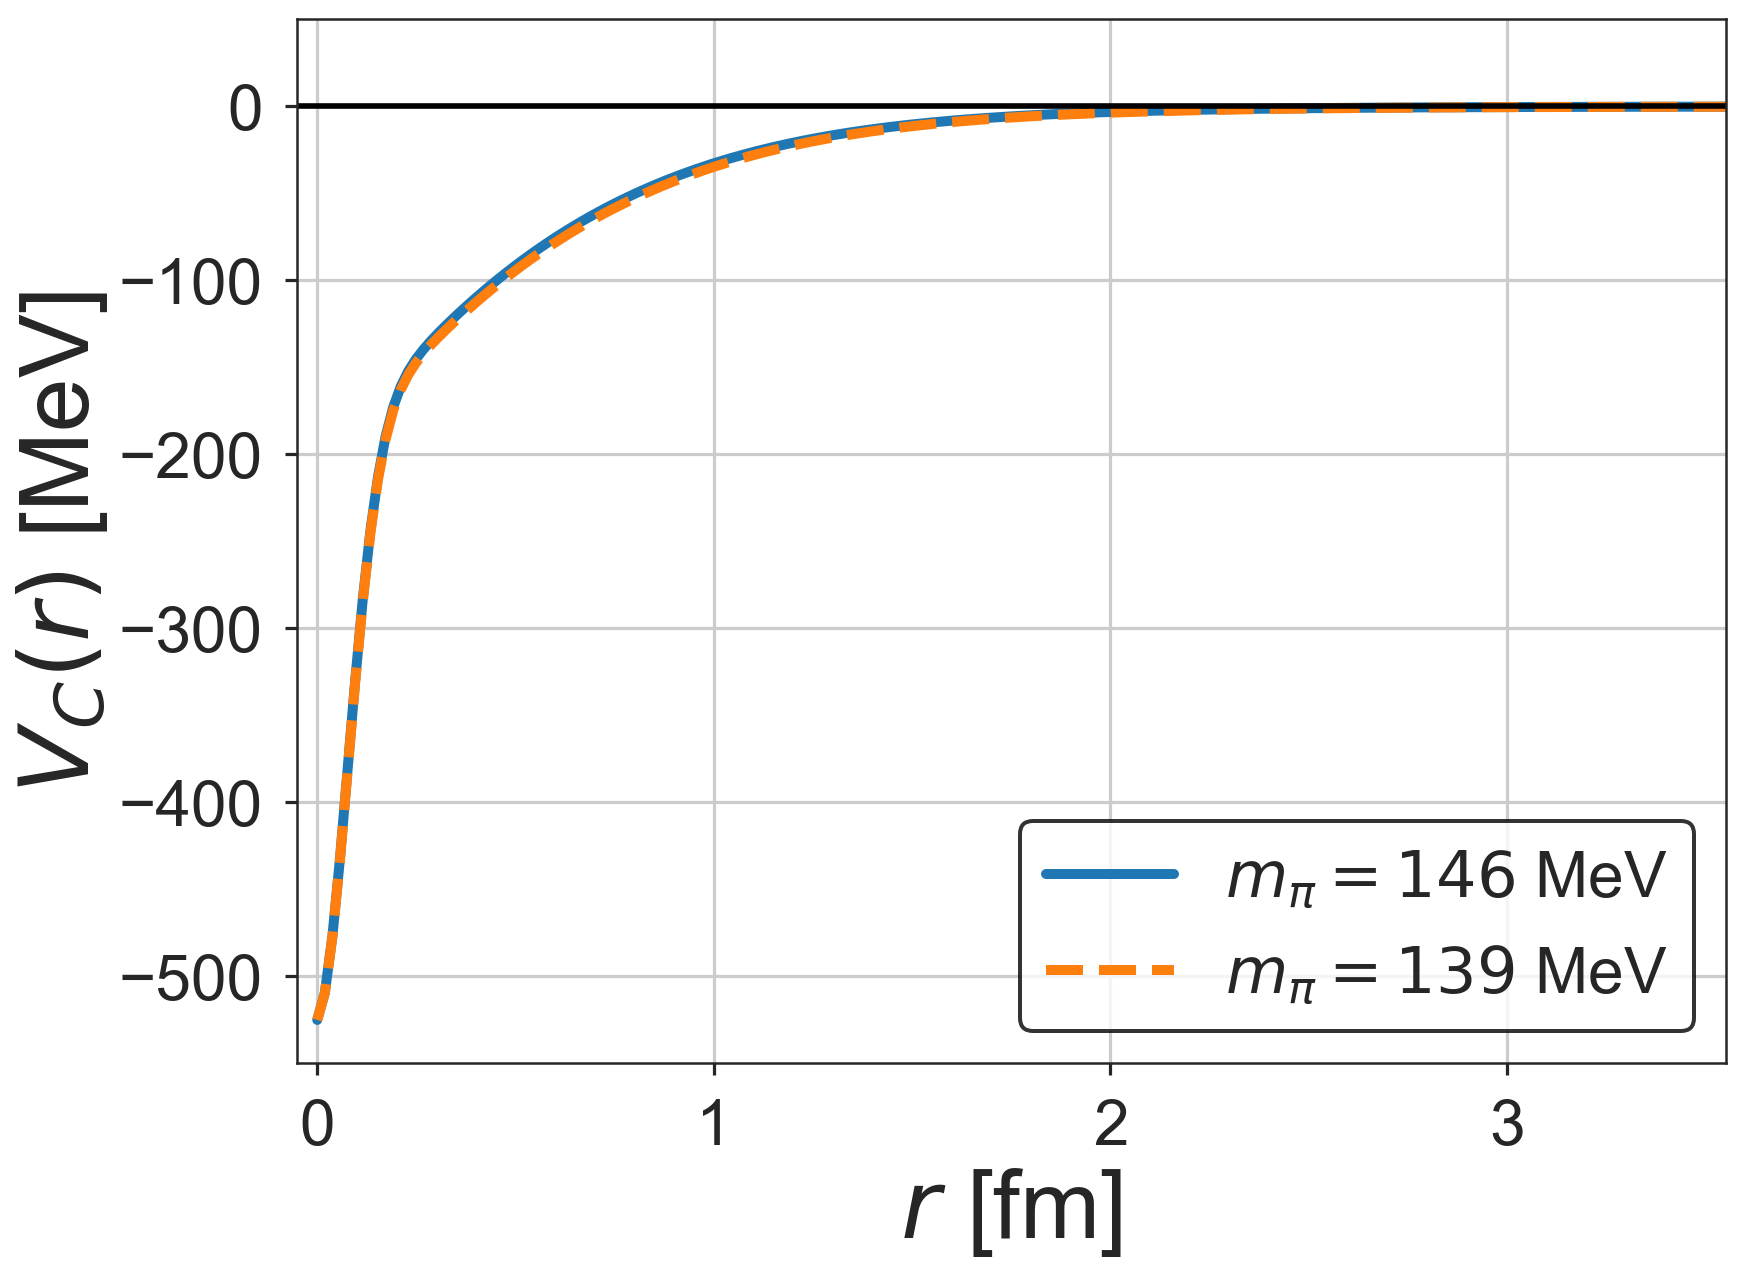

In [14]:
fig, ax = plt.subplots()
xls = np.linspace(0.01, 45, 200)
it = 12
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv, lw=5, label=r'$m_\pi = 146$ MeV')
ax.plot(xls*lat_unit, V_phys_pi(FF_yukawa2_prm_av[it], xls)*ainv, lw=5, ls='--', label=r'$m_\pi = 139$ MeV')

ax.set_ylim(-550, 50)
ax.set_xlim(-0.05, 3.55)
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_C(r)$ [MeV]', size=48)
ax.axhline(0, color='black')
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

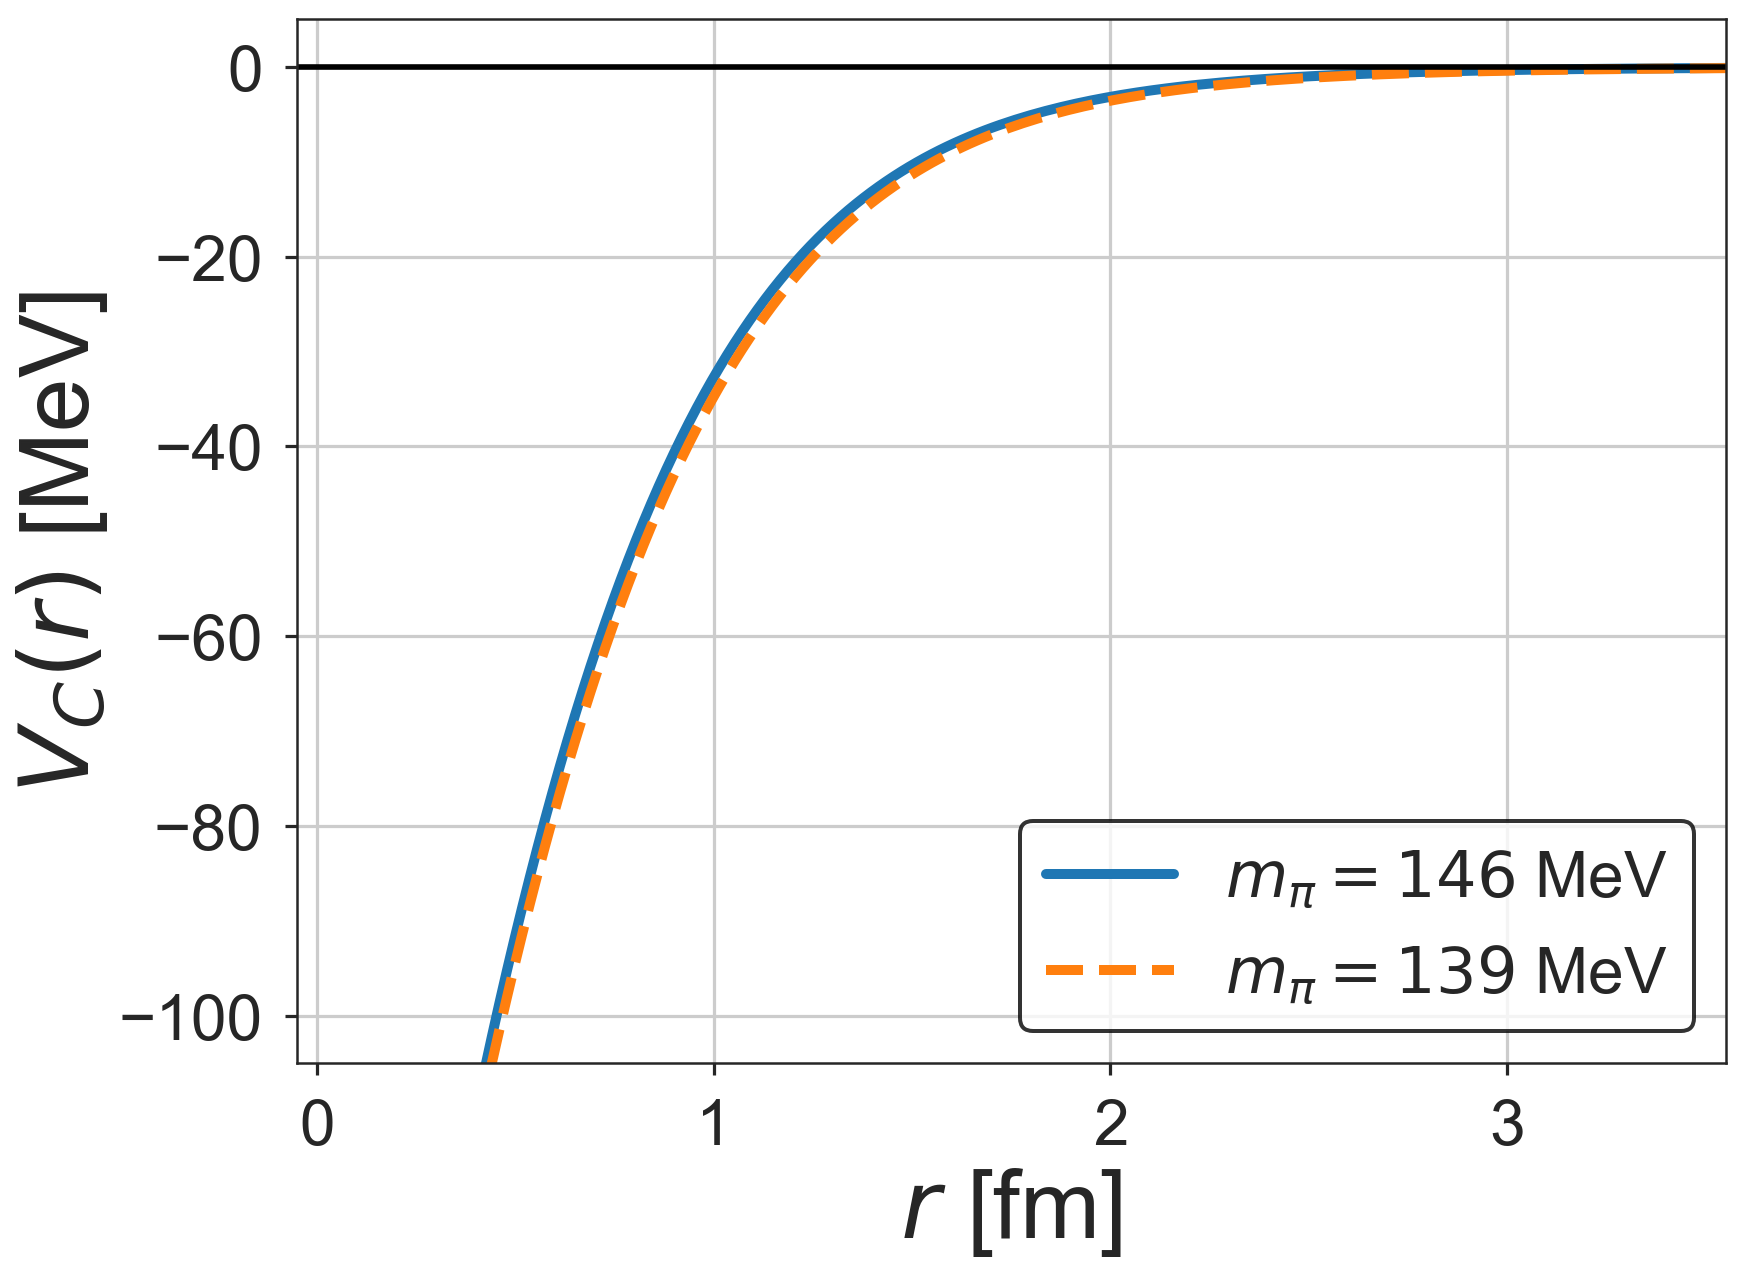

In [15]:
fig, ax = plt.subplots()
xls = np.linspace(0.01, 45, 200)
it = 12
ax.plot(xls*lat_unit, V_fit(FF_yukawa2_prm_av[it], xls)*ainv, lw=5, label=r'$m_\pi = 146$ MeV')
ax.plot(xls*lat_unit, V_phys_pi(FF_yukawa2_prm_av[it], xls)*ainv, lw=5, ls='--', label=r'$m_\pi = 139$ MeV')

ax.set_ylim(-105, 5)
ax.set_xlim(-0.05, 3.55)
ax.set_xlabel(r'$r$ [fm]', size=48)
ax.set_ylabel(r'$V_C(r)$ [MeV]', size=48)
ax.axhline(0, color='black')
leg = ax.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)

schroedinger eq. and classes (See binding energy.ipynb)

In [16]:
class Schroedinger_Eq(object):
    """Calculate the scattering phase shifts by solving Schroedinger Eq.
    
    All parameters are in lattice unit.
    """
    def __init__(self, pot, red_mass, r_min = 1.0e-5, r_max = 10/lat_unit, r_diff = 1.0e-3):
        self.pot = pot
        self.rs = np.arange(r_min, r_max, r_diff)
        self.red_mass = red_mass
        
    def sch_eq(self, uv, r, k2):
        """
        u = psi(r)/r with u(0) = 0
        solve
        u'' = - 2 mu (E - V(r)) u
        -->
        u' = v
        v' = - (k^2 - 2 mu V(r)) u
        """
        du = uv[1]
        dv = - (k2 - 2 * self.red_mass * self.pot(r)) * uv[0]
        return np.array([du, dv])
        
    def conv_delta(self, r, u, u_prime, k):
        return np.mod(np.arctan(k*u/u_prime) - k*r, np.pi)
    
    def plot_asymptotic_behavior(self, k2, u_prime_ini=1.0e-3):
        """
        This method checks convergence of the phase shift.
        """
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))
        fig, ax = plt.subplots()
        ax.plot(self.rs, self.conv_delta(self.rs, trj[:,0], trj[:,1], np.sqrt(k2)),
               label=r'$k^2 = {}$'.format(k2))
        ax.set_xlabel(r'$r$', size=48)
        ax.set_ylabel(r'$\delta$ [rad.]', size=48)
        leg = ax.legend(frameon=True)
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_linewidth(2.0)
        return ax
        
    def calc_phase_shift(self, k2, u_prime_ini=1.0e-3):
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini), self.rs,
                            args=(k2,))

        return self.conv_delta(self.rs[-1], trj[-1,0], trj[-1,1], np.sqrt(k2))       

In [17]:
class Search_Bound_State(Schroedinger_Eq):
    """
    Seach Bound State for given Schroedinger Eq.
    
    All parameters are given in lattice unit
    """
    def check_BE_window(self, Emin, Emax, u_prime_ini=1.0e-3, ax=None):
        """
        Check energy window for the binding energy
        
        Emin (Emax): lower (upper) bound
        """
        if not ax:
            fig, ax = plt.subplots()
        Es = np.linspace(Emin, Emax, 10)
        Wr = []
        for E in Es:
            # E = k^2/(2m_red)
            trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                        self.rs, args=(2.0*self.red_mass*E, ))
            Wr.append(trj[-1,1] + np.sqrt(-2.0*self.red_mass*E)*trj[-1,0])

        ax.plot(Es*ainv, Wr, '-o', color='red')
        ax.axhline(0, color='black')
        ax.set_xlabel(r'$E$ [MeV]', size=48)
        ax.set_ylabel(r'$u + \sqrt{-2m_\mu E} u$', size=48)
    
    def calc_binding_energy(self, Emin, Emax, u_prime_ini=1.0e-3):
        """
        calculate binding energy
        
        Emin (Emax): lower (upper) bound of initial energy
        """
        def cond(E):
            trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                        self.rs, args=(2.0*self.red_mass*E, ))
            return trj[-1,1] + np.sqrt(-2.0*self.red_mass*E)*trj[-1,0]
        return scipy.optimize.bisect(cond, Emin, Emax)
    
    def calc_rms_distance(self, Emin, Emax, u_prime_ini=1.0e-3):
        """
        calculate root mean square distance
        
        Emin (Emax): lower (upper) bound of initial energy
        """
        E = self.calc_binding_energy(Emin, Emax, u_prime_ini=u_prime_ini)
        trj = scipy.integrate.odeint(self.sch_eq, (0, u_prime_ini),
                                    self.rs, args=(2.0*self.red_mass*E, ))
        
        return self.root_mean_square_distance(self.rs, trj[:,0], E)
        
    def root_mean_square_distance(self, rs, u, E):
        kappa = np.sqrt(-2.0*self.red_mass*E)
        dr = rs[1] - rs[0]
        r0 = rs[-1]
        A = u[-1] * np.exp(kappa*r0)
        nume = np.sum(rs**2*u**2)*dr + A**2/(4*kappa**3) * (
            1 + 2*r0*kappa+2*r0**2*kappa**2)*np.exp(-2*kappa*r0)
        denom = np.sum(u**2)*dr + A**2*np.exp(-2*kappa*r0)/(2*kappa)
        return np.sqrt(nume/denom)

5.00 fm -> -3.31 MeV, 2.82 fm
10.00 fm -> -3.32 MeV, 2.85 fm
15.00 fm -> -3.32 MeV, 2.86 fm
20.00 fm -> -3.32 MeV, 2.86 fm
25.00 fm -> -3.32 MeV, 2.86 fm


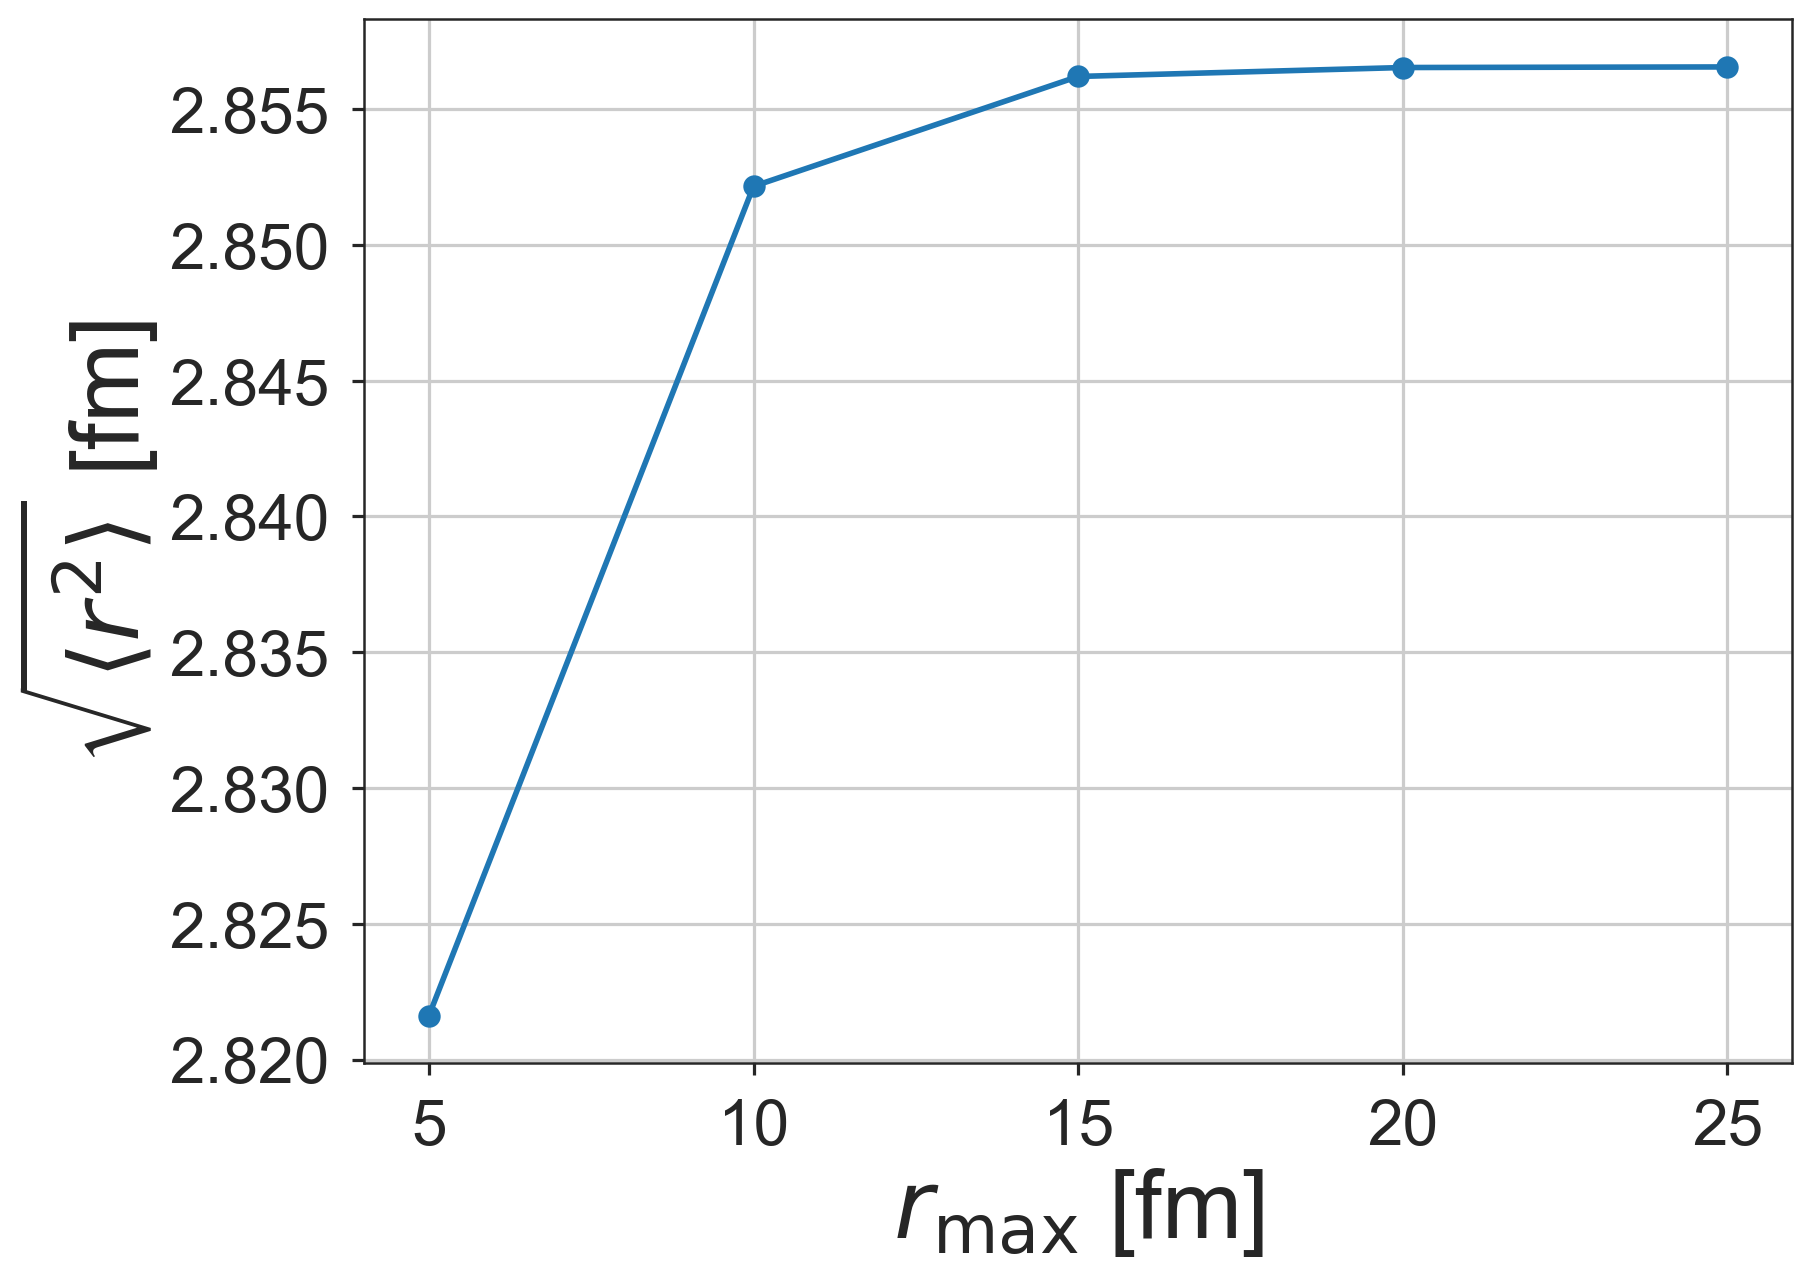

In [18]:
def check_rms_convergence(pot, Emin, Emax, rmax_list):
    rms_list = []
    for r_max in rmax_list:
        sbs = Search_Bound_State(pot, m_red, r_max = r_max)
        E = sbs.calc_binding_energy(Emin, Emax)
        rms = sbs.calc_rms_distance(Emin, Emax)
        print(f'{r_max*lat_unit:3.2f} fm -> {E*ainv:3.2f} MeV, {rms*lat_unit:3.2f} fm')
        rms_list.append(rms)
        
    fig, ax = plt.subplots()
    ax.plot(np.array(rmax_list)*lat_unit, np.array(rms_list)*lat_unit, '-o')
    ax.set_xlabel(r'$r_\mathrm{max}$ [fm]', size=48)
    ax.set_ylabel(r'$\sqrt{\langle r^2 \rangle}$ [fm]', size=48)

# example
it = 12
pot = lambda x: V_phys_pi_w_C(FF_yukawa2_prm_av[it], x)
check_rms_convergence(pot, -3.5/ainv, -1.5/ainv, np.array([5, 10, 15, 20, 25])/lat_unit)


In [19]:
FF_yukawa2_prm_jk[12].shape

(20, 4)

physical baryon masses with Coulomb interaction

In [20]:
BE_av = {}
RMS_av = {}

In [21]:
BE_jk = {}
RMS_jk = {}

In [22]:
it = 12
tmp_E = []
tmp_rms = []

for ibin in range(bin_num):
    pot = lambda x: V_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red_phys, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-5.0/ainv, -1.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-5.0/ainv, -1.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)
    
BE_jk['phys_nomega_w_C'] = np.array(tmp_E)
RMS_jk['phys_nomega_w_C'] = np.array(tmp_rms)

00 -2.34 MeV, 3.35 fm
01 -2.19 MeV, 3.45 fm
02 -2.30 MeV, 3.37 fm
03 -2.22 MeV, 3.42 fm
04 -2.04 MeV, 3.55 fm
05 -2.16 MeV, 3.46 fm
06 -2.08 MeV, 3.52 fm
07 -2.23 MeV, 3.41 fm
08 -2.24 MeV, 3.41 fm
09 -2.19 MeV, 3.44 fm
10 -2.22 MeV, 3.43 fm
11 -2.23 MeV, 3.41 fm
12 -2.15 MeV, 3.47 fm
13 -2.08 MeV, 3.52 fm
14 -2.18 MeV, 3.45 fm
15 -2.22 MeV, 3.42 fm
16 -2.21 MeV, 3.43 fm
17 -2.11 MeV, 3.50 fm
18 -2.12 MeV, 3.49 fm
19 -2.10 MeV, 3.51 fm


In [23]:
pot = lambda x: V_w_C(FF_yukawa2_prm_av[it], x)
sbs = Search_Bound_State(pot, m_red_phys, r_max=30/lat_unit)
E = sbs.calc_binding_energy(-5.0/ainv, -1.5/ainv)
print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
BE_av['phys_nomega_w_C'] = E
    
rms = sbs.calc_rms_distance(-5.0/ainv, -1.5/ainv)
print(f' {rms*lat_unit:3.2f} fm')
RMS_av['phys_nomega_w_C'] = rms


19 -2.18 MeV, 3.45 fm


In [24]:
it = 12
tmp_E = []
tmp_rms = []

for ibin in range(bin_num):
    pot = lambda x: V_phys_pi_w_C(FF_yukawa2_prm_jk[it][ibin,:], x)
    sbs = Search_Bound_State(pot, m_red_phys, r_max=30/lat_unit)
    E = sbs.calc_binding_energy(-5.0/ainv, -1.5/ainv)
    print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
    tmp_E.append(E)
    
    rms = sbs.calc_rms_distance(-5.0/ainv, -1.5/ainv)
    print(f' {rms*lat_unit:3.2f} fm')
    tmp_rms.append(rms)
    
BE_jk['phys_masses_w_C'] = np.array(tmp_E)
RMS_jk['phys_masses_w_C'] = np.array(tmp_rms)

00 -3.18 MeV, 2.94 fm
01 -3.01 MeV, 3.01 fm
02 -3.14 MeV, 2.95 fm
03 -3.04 MeV, 2.99 fm
04 -2.83 MeV, 3.08 fm
05 -2.98 MeV, 3.02 fm
06 -2.87 MeV, 3.06 fm
07 -3.06 MeV, 2.98 fm
08 -3.07 MeV, 2.98 fm
09 -3.01 MeV, 3.00 fm
10 -3.04 MeV, 2.99 fm
11 -3.06 MeV, 2.98 fm
12 -2.96 MeV, 3.03 fm
13 -2.87 MeV, 3.06 fm
14 -3.00 MeV, 3.01 fm
15 -3.05 MeV, 2.99 fm
16 -3.04 MeV, 2.99 fm
17 -2.92 MeV, 3.04 fm
18 -2.92 MeV, 3.04 fm
19 -2.90 MeV, 3.05 fm


In [25]:
pot = lambda x: V_phys_pi_w_C(FF_yukawa2_prm_av[it], x)
sbs = Search_Bound_State(pot, m_red_phys, r_max=30/lat_unit)
E = sbs.calc_binding_energy(-5.0/ainv, -1.5/ainv)
print(f'{ibin:02d} {E*ainv:3.2f} MeV', end=',')
BE_av['phys_masses_w_C'] = E
    
rms = sbs.calc_rms_distance(-5.0/ainv, -1.5/ainv)
print(f' {rms*lat_unit:3.2f} fm')
RMS_av['phys_masses_w_C'] = rms

19 -3.00 MeV, 3.01 fm


summarize parameters

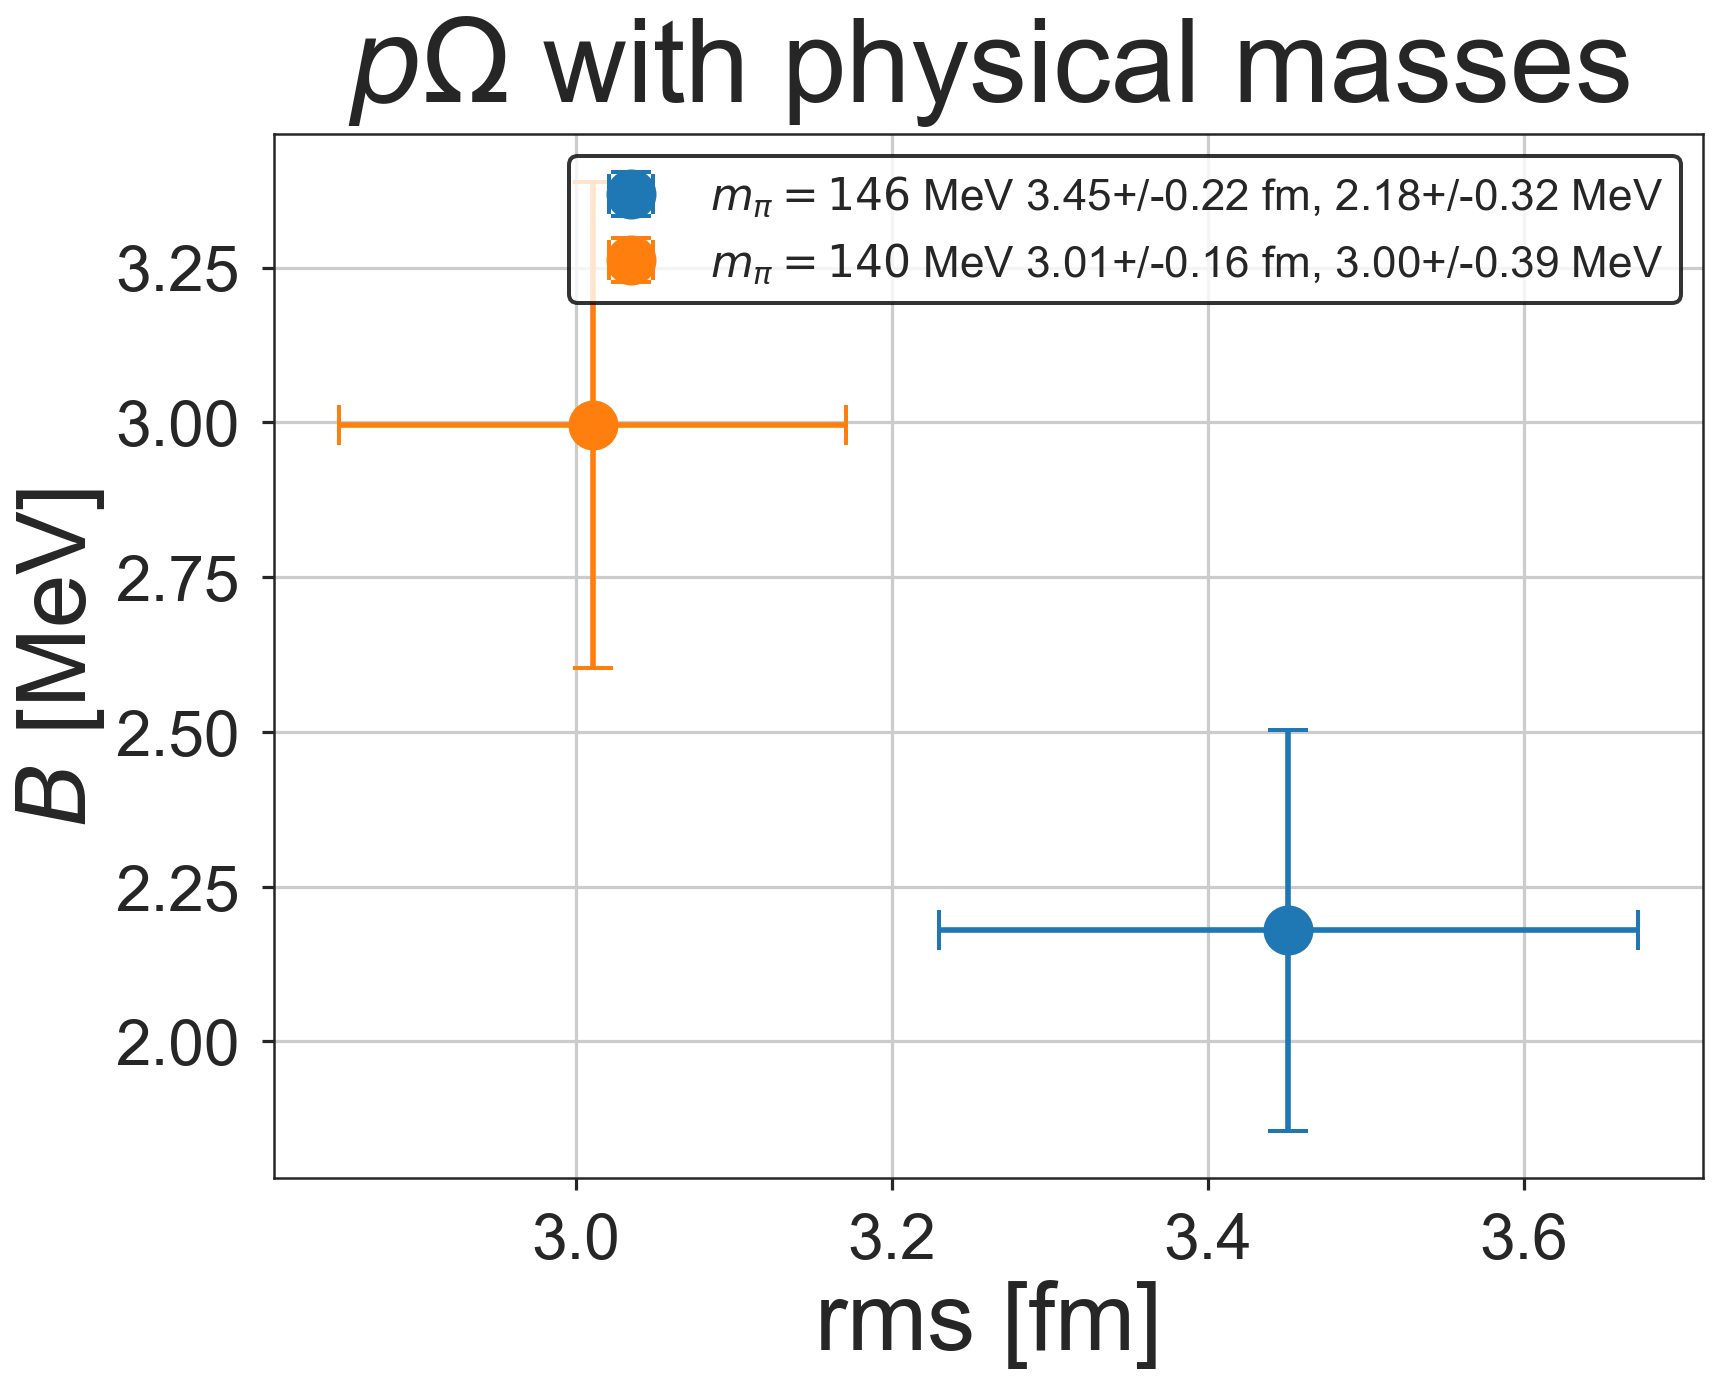

In [26]:
fig, ax = plt.subplots()
ax.set_title(r'$p\Omega$ with physical masses', y=1.02, fontsize=58)
for key, ll in zip(['phys_nomega_w_C', 'phys_masses_w_C'], 
                   [r'$m_\pi = 146$ MeV', r'$m_\pi = 140$ MeV']):
    xs = RMS_av[key]*lat_unit, RMS_jk[key].std()*np.sqrt(bin_num-1)*lat_unit
    ys = -BE_av[key]*ainv, BE_jk[key].std()*np.sqrt(bin_num-1)*ainv
    
    ax.errorbar(xs[0], ys[0], ys[1], xerr=xs[1], capsize=10, capthick=2.0,
               fmt='o', ms=25, label=r'{} {:3.2u} fm, {:3.2u} MeV'.format(ll, ufloat(xs[0], xs[1]),
                                                               ufloat(ys[0], ys[1])))
leg = ax.legend(frameon=True, fontsize=22)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2.0)
ax.set_ylabel(r'$B$ [MeV]', fontsize=48)
ax.set_xlabel(r'rms [fm]', fontsize=48);